In [1]:
%matplotlib inline

# Volumetric Registration
In this tutorial we align a mouse brain to the Allen Referece Atlas (ARA).  Thus the ARA is our _reference_ image, it consists of image data stored in the default "average" channel and corresponding annotations stored in a separate "annotation" channel.  We begin by importing the relevant modules

In [2]:
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata

We define the server and our user token

In [3]:
server = "dev.neurodata.io"
userToken = txtRead("../userToken.pem").strip()

First we'll download the atlas image

In [4]:
refToken = "ara3"
refImg = imgDownload(refToken, channel="average", server=server, userToken=userToken)

Next we'll visuaize the image.  To ensure that the visuization is has good contrast we'll only show intensity values below the 99th percentile.

In [5]:
refThreshold = imgPercentile(refImg, 0.99)
print(refThreshold)

269.129411765


When given an image volume *imgShow* displays it as a set of evenly spaced z-slices (1st column), y-slices (2nd column) and x slices (3rd column).

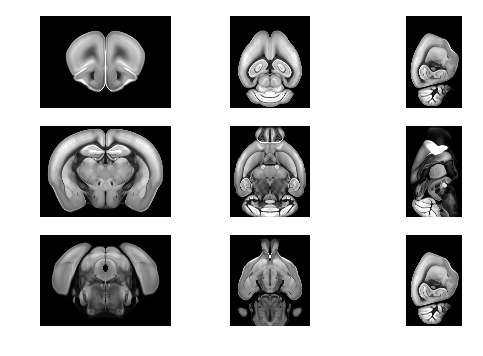

In [6]:
imgShow(refImg, vmax=refThreshold)

Now we download the corresponding annotations

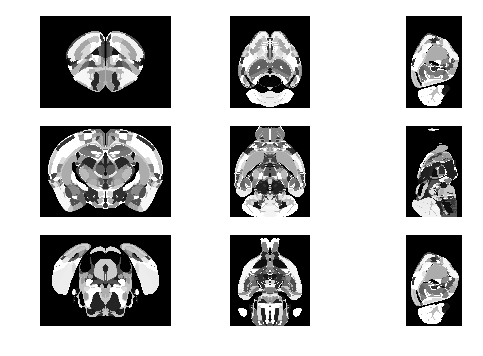

In [7]:
refAnnoImg = imgDownload(refToken, channel="annotation", server=server, userToken=userToken)
imgShow(refAnnoImg, vmax=1000)

It's usually better to visuaize a set of annotations in color.  Let's display the atlas annotations using a random colormap.  We begin by creating a 1000x3 array of random values. Since we always want the backgrond (label 0) to be dark we make the 0th row is [0,0,0].

In [8]:
randValues = np.random.rand(1000,3)
randValues = np.concatenate(([[0,0,0]],randValues))

Now we can display the annotations.

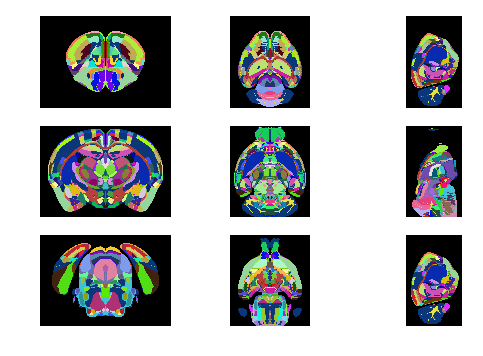

In [9]:
randCmap = matplotlib.colors.ListedColormap (randValues)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

Let's overlay these annotations on the atlas image using alpha transparency.  To do this we must set *newFig* to *False* so that matplotlib appends the annotation data to the current figure instead of creating new one.  

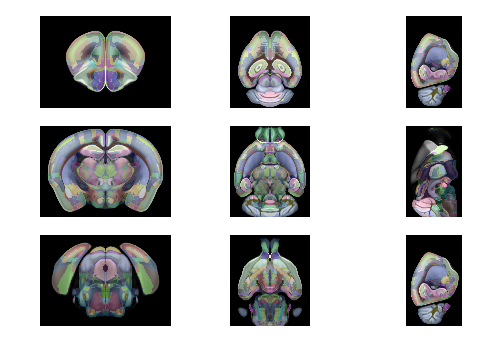

In [10]:
imgShow(refImg, vmax=refThreshold, newFig=False)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.3, newFig=False)
plt.show()

## Downloading input image
*ndstore* stores the brains at multiple resolutions. Resolution 0 is always the highest resolution each subsequent resoltion takes up 1/4th (under slice scaling) or 1/8th (under isotropic scaling) as many bytes as the previous resoltion.  We can use ndio's get_metadata method to see a list of available resoltions.

In [11]:
inToken = "s3617"
nd = neurodata(hostname="dev.neurodata.io", user_token=userToken)
print(nd.get_metadata(inToken)['dataset']['imagesize']) 

{u'1': [7379, 10491, 1280], u'0': [14757, 20982, 1280], u'3': [1845, 2623, 1280], u'2': [3690, 5246, 1280], u'5': [462, 656, 1280], u'4': [923, 1312, 1280], u'6': [231, 328, 1280]}


Clearly resolution 6 is a resonable resolution.  So we'll download the image at that resolution.  Depending on your internet connection downloading may take several minutes.

In [12]:
inImg = imgDownload(inToken, resolution=6, userToken=userToken, server=server)
inImgOrig = inImg[:,:,:]

We'll only use intensity values below the 99th percentile in the visualization.

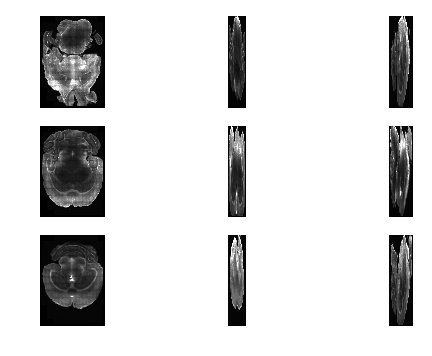

In [13]:
inThreshold = imgPercentile(inImg, 0.99)
imgShow(inImg, vmax=inThreshold)

## Reorienting input image
You may have noticed that the input brain is not oriented in the same way as the atlas.  Let's look at the atlas.

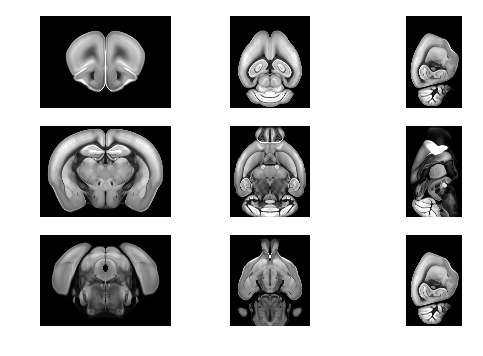

In [14]:
imgShow(refImg, vmax=refThreshold)

By examining the the z slices in the first column its clear that the x-axis goes from **R**ight to Left side of the brain. The y-axis varies from **S**uperior to Inferior and the z-axis goes from **A**nterior to posterior.  Thus it is in **RSA** orientation.  Looking at the the input brain...

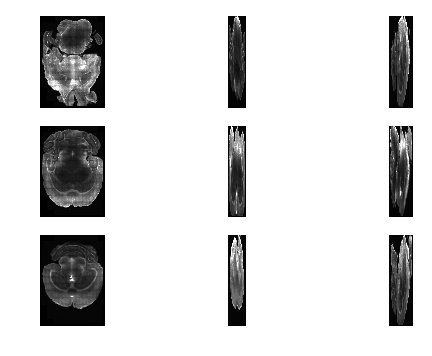

In [15]:
imgShow(inImg, vmax=inThreshold)

...we see that the x-axis goes from **R**ight to Left, the y-axis goes from **P**osterior to Anterior and the Z axis goes from **I**nferior to Superior.  Thus it's in **RPI** orientation.  Therefore we reorient the input image from **RPI** to **RSA**

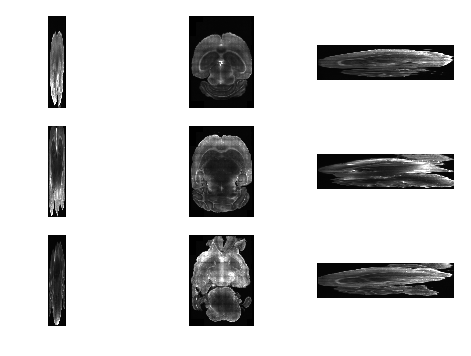

In [16]:
inOrient = "RPI"
refOrient = "RSA"
inImg = imgReorient(inImg, inOrient, refOrient)
imgShow(inImg, vmax=inThreshold)

Compare the above to the Atlas.  The slices should now correspond with the atlas.  Let's make a copy of the reorianted image size and spacing because we'll need it later.

In [17]:
inImgSize_reorient = inImg.GetSize()
inImgSpacing_reorient= inImg.GetSpacing()

## Downample images
Now we downsample the input and reference images to a more manageable size

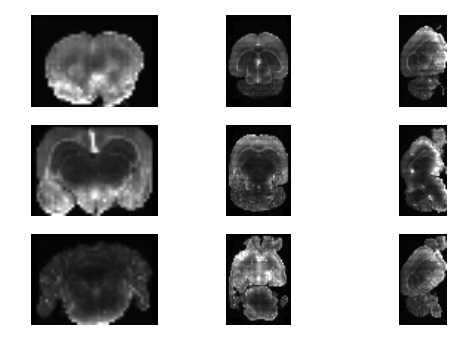

In [18]:
spacing = [0.2,0.2, 0.2]
inImg_ds = imgResample(inImg, spacing)
imgShow(inImg_ds, vmax=inThreshold)

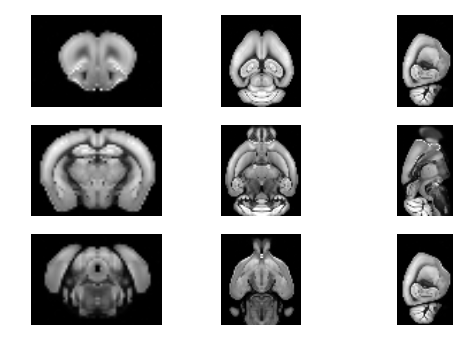

In [19]:
refImg_ds = imgResample(refImg, spacing)
imgShow(refImg_ds, vmax=refThreshold)

# Affine Registration
Now we compute the affine transform.  Unlike in the [basic registration tutiorial](basicRegistration.ipynb) we'll use the *imgAffineComposite* instead of *imgAffine*.  *imgAffine* simply computes the affine transform between the input and reference images.  *imgAffineComposite* computes a translation then a rigid then an affine transformation.  It's output is the composition of those three transforms.  We use Mutual Information since the input and reference images have very differnt intensity profiles.  We also enable the *verbose* option so that each iteration is printed.

In [20]:
affine = imgAffineComposite(inImg_ds, refImg_ds, iterations=200, useMI=True, verbose=True)

Step translation:
0.	 -0.209038185783
1.	 -0.237406316944
2.	 -0.240465260285
3.	 -0.254950226461
4.	 -0.235778877074
5.	 -0.262612006428
6.	 -0.29163304094
7.	 -0.281356885738
8.	 -0.307657079923
9.	 -0.313123614653
10.	 -0.325719948268
11.	 -0.349017462349
12.	 -0.353756652145
13.	 -0.343602096593
14.	 -0.360709385131
15.	 -0.388596246795
16.	 -0.393843248735
17.	 -0.405804536947
18.	 -0.41064625389
19.	 -0.414506512001
20.	 -0.413226444982
21.	 -0.387910681913
22.	 -0.413697253076
23.	 -0.413670257805
24.	 -0.413716612471
25.	 -0.413672582268
26.	 -0.387918893556
27.	 -0.413847362318
Step scale:
0.	 -0.460947287302
1.	 -0.466392199998
2.	 -0.487433764927
3.	 -0.485196881914
4.	 -0.488707986878
5.	 -0.487941042886
6.	 -0.488810242432
7.	 -0.488777095887
8.	 -0.488932318359
Step rigid:
0.	 -0.4743960526
1.	 -0.313877420319
2.	 -0.438245611792
3.	 -0.482965942119
4.	 -0.47288132892
5.	 -0.485794489136
6.	 -0.485395331452
7.	 -0.486658890796
8.	 -0.486196344951
9.	 -0.486778714653
10.	 

Now we apply the affine transform to the input image and mask

[0.8843998949645142, 0.0539613020697283, 0.01864435671316838, -0.026516961176181877, 0.9663370108245692, -0.00878922893945813, 0.02430230360944436, 0.05190069181470488, 0.9314380593219584, -1.0808233606507807, -0.11844606655647694, -1.1696825396231014]


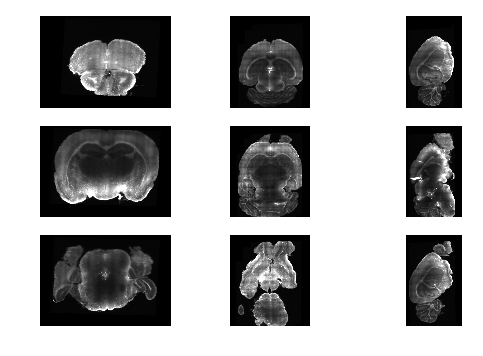

In [21]:
print(affine)
inImg_affine = imgApplyAffine(inImg, affine, size=refImg.GetSize(), spacing=refImg.GetSpacing())
imgShow(inImg_affine, vmax=inThreshold)

We slightly adjust the affine to shrink the brain in the anterior-posterior direction.  This reduces the chance that the olfalctory bulbs are misaligned

[0.8843998949645142, 0.0539613020697283, 0.021441010220143636, -0.026516961176181877, 0.9663370108245692, -0.01010761328037685, 0.02430230360944436, 0.05190069181470488, 1.071153768220252, -1.1087898957205333, -0.10526222314728974, -2.566839628606039]


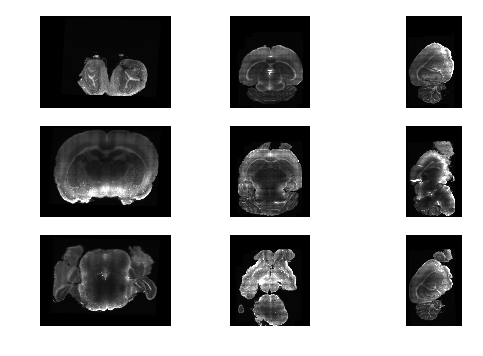

In [22]:
adjustAffine = [1, 0, 0, 0, 1, 0, 0, 0, 1.15, 0, 0, -1.5]
#adjustAffine = [1, 0, 0, 0, 1, 0, 0, 0, 1.1, 0, 0, -1]
affine2 = affineApplyAffine(adjustAffine, affine)
print(affine2)
inImg_affine = imgApplyAffine(inImg, affine2, size=refImg.GetSize(), spacing=refImg.GetSpacing())
imgShow(inImg_affine, vmax=inThreshold)

We can evaluate the affine registration by generating a checkerboard of the reference and input images.  In this method the input image is placed on the black squares of the metaphorical checkerboard while the reference image is placed on the red squares.  Idealy anatomical sturctures should line up across squares.

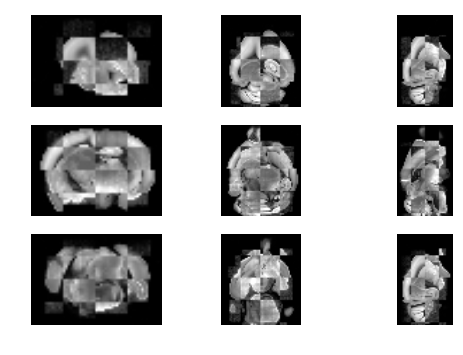

In [23]:
inImg_ds = imgResample(inImg_affine, spacing=spacing, size=refImg_ds.GetSize())
imgShow(imgChecker(inImg_ds, refImg_ds), vmax=refThreshold)

## LDDMM registration
Now we run LDDMM registration. Here we use *imgMetamorphosisComposite*.  Unlike *imgMetamorphosis* introduced in the [2D registration notebook](2D_Registration.ipynb), this function runs LDDMM in multiple steps using the alpha values specified by in *alphaList*. The *field* and *invField* outputs are the composition of all steps.  Once agan we use a Mutual Information cost because the input brain and reference image have very differnt intensity profiles.

In [24]:
inImg_ds = imgResample(inImg_affine, spacing=spacing, size=refImg_ds.GetSize())
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, alphaList=[0.2, 0.1, 0.05],
                                              scaleList = 1.0, useMI=True, iterations=200, verbose=True)


Step 0: alpha=0.2, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-2.38798e+10, 12.0683, 0, -2.38798e+10 (97.2901%), 1.100000e-03
1.	-2.39193e+10, 14.6902, 0, -2.39193e+10 (97.2508%), 3.025000e-04
2.	-2.39193e+10, 14.6902, 0, -2.39193e+10 (97.2508%), 1.586676e-10
E = -2.39193e+10 (97.2508%)
Length = 10.6019
Time = 16.8391s (0.280651m)

Step 1: alpha=0.1, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-2.49736e+10, 11.0436, 0, -2.49736e+10 (98.9155%), 1.100000e-03
1.	-2.50853e+10, 11.704, 0, -2.50853e+10 (98.801%), 1.210000e-03
2.	-2.51369e+10, 20.3756, 0, -2.51369e+10 (98.7481%), 1.331000e-03
3.	-2.54082e+10, 39.015, 0, -2.54082e+10 (98.4699%), 1.464100e-03
4.	-2.55464e+10, 63.0113, 0, -2.55464e+10 (98.3283%), 1.610510e-03
5.	-2.58827e+10, 104.011, 0, -2.58827e+10 (97.9835%), 1.771561e-03
6.	-2.62653e+10, 143.72, 0, -2.62653e+10 (97.5913%), 1.948717e-03
7.	-2.6542e+10, 197.45, 0, -2.6542e+10 (97.3076%), 2.143589e-03

Now we apply the displacement field

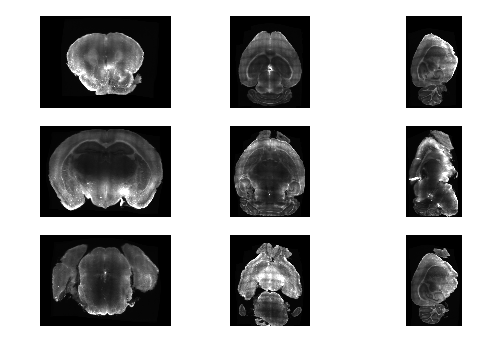

In [25]:
inImg_lddmm = imgApplyField(inImg_affine, field, size=refImg.GetSize())
imgShow(inImg_lddmm, vmax=inThreshold)

### Evaluation LDDMM registration
Now we evaluate the deformable registration using a checkerboard image

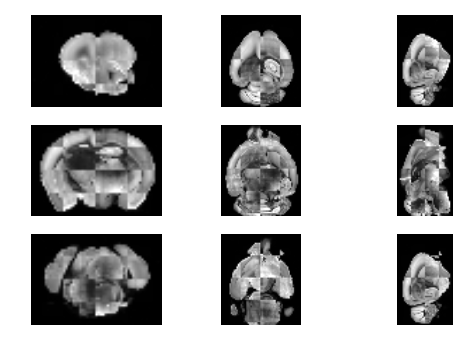

In [26]:
inImg_ds = imgResample(inImg_lddmm, spacing=spacing, size=refImg_ds.GetSize())
imgShow(imgChecker(inImg_ds, refImg_ds), vmax=refThreshold)

We can also evaluate the registration by overlaying the atlas annotations over the deformed input image.

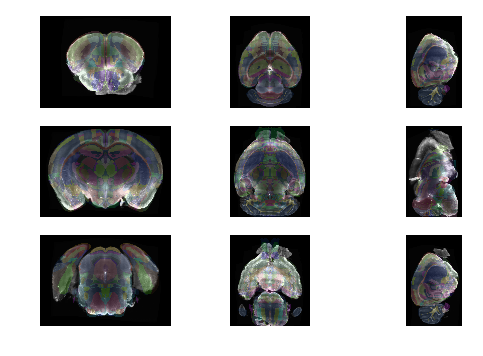

In [27]:
imgShow(inImg_lddmm, vmax=inThreshold, newFig=False)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, newFig=False)
plt.show()

## Uploading Results

### Uploading deformed input image
We can now upload the atlas-aligned input brain back into ndstore.

In [31]:
outToken = inToken + "_to_" + refToken
imgUpload(inImg_lddmm, outToken, channel="ch0", server=server, userToken=userToken)

We now generate an ndviz url for visualization on the web

In [30]:
vizUrl([outToken, refToken], ["ch0", "annotation"], server, userToken)

"https://mri.neurodata.io/ndviz/#!{'layers':{'annotation?neariso=false':{'source':'ndstore://https://dev.neurodata.io/ara3/annotation?neariso=false'_'type':'segmentation'}_'ch0?neariso=false':{'source':'ndstore://https://dev.neurodata.io/s3617_to_ara3/ch0?neariso=false'_'type':'image'}}_'layout':'4panel'}"

### Uploading deformed atlas annotations

In [32]:
spacing_ds = invField.GetSpacing()
size_ds = np.ceil(np.array(refAnnoImg.GetSize())*np.array(refAnnoImg.GetSpacing())/np.array(spacing_ds))
size_ds = list(size_ds.astype(int))

Before we can overlay the atlas annotations on the downloaded image we must transfom them to its space. Fortunatly this can be done since all spatial transforms in this tutorial are invertable.  First we construct an inverse displacement field which transforms the annotations from the reference space to the input space before registration.

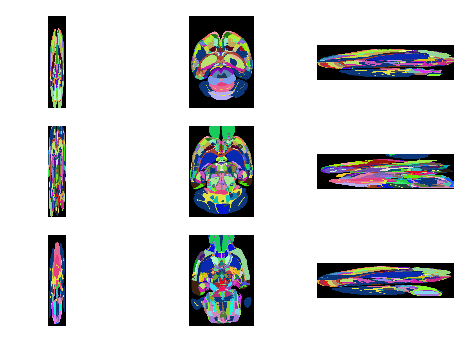

In [35]:
affine = affine2
invAffine = affineInverse(affine)
invAffineField = affineToField(invAffine, size_ds, spacing_ds)
invField2 = fieldApplyField(invAffineField, invField)
inAnnoImg = imgApplyField(refAnnoImg, invField2,useNearest=True, size=inImgSize_reorient, spacing=inImgSpacing_reorient)
inAnnoThreshold = imgPercentile(inAnnoImg,0.99)
imgShow(inAnnoImg, vmax=1000, cmap=randCmap)

Were not done yet.  We still need to reorient these annotations to their original  

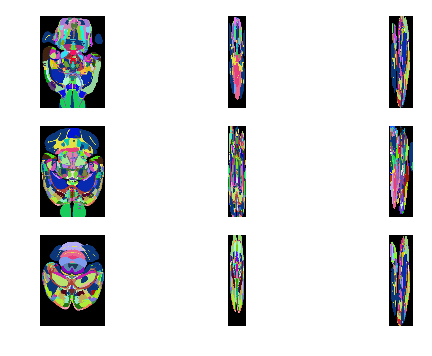

In [37]:
inAnnoImg = imgReorient(inAnnoImg, refOrient, inOrient)
imgShow(inAnnoImg, vmax=1000, cmap=randCmap)

We can upload these annotations at the lowest possible resolution.

In [38]:
inAnnoToken = refToken + "_to_" + inToken
imgUpload(inAnnoImg, inAnnoToken, resolution=6)
vizUrl([inAnnoToken, inToken], ["annotation", "ch0"], server, userToken)

"https://mri.neurodata.io/ndviz/#!{'layers':{'annotation?neariso=false':{'source':'ndstore://https://dev.neurodata.io/ara3_to_s3617/annotation?neariso=false'_'type':'segmentation'}_'ch0?neariso=false':{'source':'ndstore://https://dev.neurodata.io/s3617/ch0?neariso=false'_'type':'image'}}_'layout':'4panel'}"